# Setup

In [3]:
# Importing the libraries
import numpy as np                                # Numerical operations
import pandas as pd                               # Data manipulation
import matplotlib.pyplot as plt                   # Basic plotting
import seaborn as sns                             # Statistical visualizations

from sklearn.preprocessing import LabelEncoder       # Encode categorical labels
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (                        # Model evaluation metrics
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split  # Data splitting

from imblearn.over_sampling import SMOTE              # Synthetic minority oversampling
from imblearn.pipeline import Pipeline                # Build ML pipelines

#Path setup
import os                             # Operating system utilities
from pathlib import Path              # Object-oriented filesystem paths
notebook_path = Path().absolute()     # Current notebook location
project_root = notebook_path.parent   # Project root directory

In [4]:
#df = pd.read_csv('data_lakehouse/gold/starG.csv')
df = pd.read_csv(project_root/'data'/'gold'/'starG_harvard.csv')
df

,identifier,observation_id,observation_date,harvard_classification,harvard_subclass,class,full_class,effective_temperature,log_surface_gravity,metallicity_fe_h,radial_velocity,redshift
0,3007021652015-01-19 12:00:00,300702165,2015-01-19 12:00:00,K,K3,K,K4,4729.36,4.741,-0.128,42.15,0.000141
1,2151092011-10-23 12:00:00,215109,2011-10-23 12:00:00,K,K3,G,G8,4642.57,4.662,-0.363,36.61,0.000122
2,181121112011-12-18 12:00:00,18112111,2011-12-18 12:00:00,K,K3,K,K3,4664.49,4.690,-0.207,35.04,0.000117
3,3674121992015-10-07 12:00:00,367412199,2015-10-07 12:00:00,K,K2,G,G9,4960.44,4.613,-0.262,-35.46,-0.000118
4,181121792011-12-18 12:00:00,18112179,2011-12-18 12:00:00,G,K0,G,G8,5371.04,4.296,-0.248,-29.91,-0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,6860020462018-10-30 12:00:00,686002046,2018-10-30 12:00:00,F,G0,F,F2,6061.88,3.811,-0.240,9.94,0.000033
49996,3819020372015-11-02 12:00:00,381902037,2015-11-02 12:00:00,F,G1,F,F2,6033.30,4.190,-0.458,35.12,0.000117
49997,3819020432015-11-02 12:00:00,381902043,2015-11-02 12:00:00,K,K1,G,G9,5066.79,3.210,-0.247,-26.94,-0.000090
49998,2542040182014-10-14 12:00:00,254204018,2014-10-14 12:00:00,G,G8,G,G7,5571.65,4.073,0.435,1.68,0.000006


# 1. Class Classification

In [6]:
# Configuration
TARGET_COLUMN    = ['class']                                   # Target label
# FEATURE_COLUMNS  = ['effective_temperature_2',                 # Input features
#                     'radius', 'mass', 'distance']

FEATURE_COLUMNS = [
    'effective_temperature', 'log_surface_gravity',
    'metallicity_fe_h', 'radial_velocity', 'redshift'
]

# Data preparation
label_encoder = LabelEncoder()                                 # Initialize label encoder
y = label_encoder.fit_transform(df[TARGET_COLUMN])           # Encode target variable
X = df[FEATURE_COLUMNS]                                      # Select features

# Stratified train-test split
X_train, X_val, y_train, y_val = train_test_split(             # Split dataset
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Class balancing with SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)  # Initialize SMOTE
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)   # Apply to training data

# Model training
model = RandomForestClassifier(                                # Random Forest classifier
    n_estimators=20,                                           # Number of trees
    max_depth=10,                                               # Maximum tree depth
    bootstrap=True,                                            # Use bootstrapping
    class_weight='balanced_subsample',                         # Class weighting
    random_state=42                                            # Seed
)
model.fit(X_train_res, y_train_res)                            # Train on resampled data

# Evaluation
y_pred = model.predict(X_val)                                  # Predict on validation set
print("\n=== Enhanced Evaluation ===")                         
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")  # Print accuracy
print("\nClassification Report:")                              
print(classification_report(y_val, y_pred,                      # Report metrics
                            target_names=label_encoder.classes_,
                            zero_division=0))

# Model wrapper for reuse
def class_classifier():
    return model

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== Enhanced Evaluation ===
Validation Accuracy: 0.8704

Classification Report:
              precision    recall  f1-score   support

           A       0.35      0.82      0.49        17
           F       0.91      0.74      0.82      1304
           G       0.85      0.91      0.88      2513
           K       0.89      0.93      0.91      1166

    accuracy                           0.87      5000
   macro avg       0.75      0.85      0.77      5000
weighted avg       0.87      0.87      0.87      5000



In [7]:
# Initialize models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42, bootstrap=True, # Use bootstrapping
    class_weight='balanced_subsample'),   # Class weighting
    'KNeighborsClassifier': KNeighborsClassifier(),
    #'SVC': SVC(random_state=42),
    'GaussianNB': GaussianNB()
}

best_accuracy = 0
best_model = None
best_model_name = ""
best_cm = None

# Train and evaluate each model
for model_name, model in models.items():
    # Apply SMOTE to training data
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    train_accuracy = accuracy_score(y_train_res, model.predict(X_train_res))
    
    # Print results
    print(f'\n[******* {model_name} ******]')
    print(f'\n   Validation Accuracy: {accuracy:.4f}')
    print(f'   Training Accuracy: {train_accuracy:.4f}')
    print('\n', classification_report(y_val, y_pred, target_names=label_encoder.classes_, zero_division=0))
    
    # Store best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name
        best_cm = confusion_matrix(y_val, y_pred)

# Print model scores
print("\nModel Performance Summary:")
for model_name, model in models.items():
    print(f"{model_name}: {model.score(X_val, y_val)*100:.2f}%")

# Set best model to original variable names
model = best_model
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")

# Confusion matrix of best model (matches original variable name)
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

# For next cell compatibility:
# model, y_pred, and cm variables are ready for plotting

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



[******* LogisticRegression ******]

   Validation Accuracy: 0.6784
   Training Accuracy: 0.7711

               precision    recall  f1-score   support

           A       0.05      1.00      0.10        17
           F       0.60      0.73      0.66      1304
           G       0.80      0.54      0.65      2513
           K       0.75      0.92      0.83      1166

    accuracy                           0.68      5000
   macro avg       0.55      0.80      0.56      5000
weighted avg       0.74      0.68      0.69      5000


[******* DecisionTreeClassifier ******]

   Validation Accuracy: 0.8126
   Training Accuracy: 1.0000

               precision    recall  f1-score   support

           A       0.46      0.76      0.58        17
           F       0.75      0.80      0.77      1304
           G       0.84      0.79      0.81      2513
           K       0.84      0.88      0.86      1166

    accuracy                           0.81      5000
   macro avg       0.72      0.81  

For a better visualization of the accuracy of RandomForestClassifier.

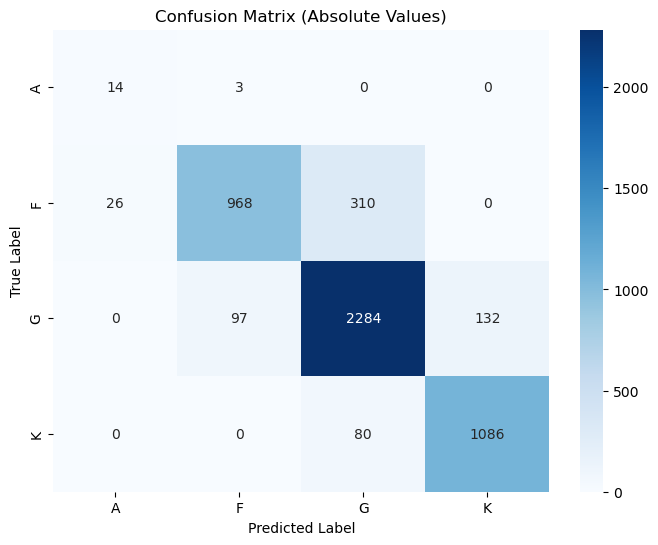

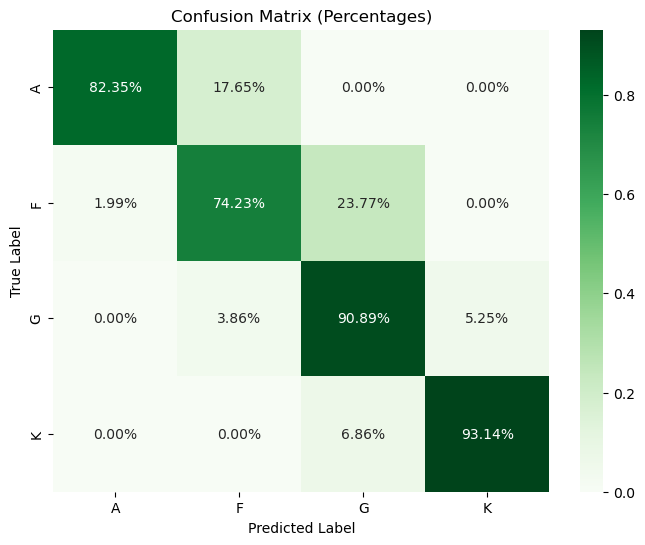

In [9]:
# Confusion matrix visualizations
cm = best_cm     # Compute confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize by row

plt.figure(figsize=(8, 6))                                          # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',                  # Absolute values heatmap
            xticklabels=label_encoder.classes_,                    
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Absolute Values)')                     
plt.ylabel('True Label')                                            
plt.xlabel('Predicted Label')                                       
plt.show()

plt.figure(figsize=(8, 6))                                          # Set figure size
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',   # Normalized heatmap
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# 2. SubClass Classification

First, let's filter some subclasses that have few entries

In [12]:
# 1. Count and display the number of entries per category
print("\n=== Category Counts for 'sub_class' ===")
print(df['full_class'].value_counts())

# 2. Define minimum count threshold (customizable)
MIN_COUNT = 10  # Modify this value as needed

# 3. Filter out classes with fewer entries than MIN_COUNT
valid_classes = df['full_class'].dropna().value_counts()
valid_classes = valid_classes[valid_classes >= MIN_COUNT].index

df_filtered = df[df['full_class'].isin(valid_classes)].reset_index(drop=True).dropna()

print("\n=== Remaining Classes After Filtering ===")
print(df_filtered['full_class'].value_counts())


=== Category Counts for 'sub_class' ===
full_class
G3       5375
G2       3846
K5       3813
G7       3374
F9       3097
G8       3059
G5       2911
F5       2638
K3       2371
K7       2146
G0       1872
F7       1857
F2       1712
K1       1482
F0       1465
G4       1391
F6       1355
G9       1347
G6       1289
K4        886
K0        807
G1        669
F8        414
F3        268
F4        230
K2        152
A7V        56
A6IV       42
A5V        20
A7IV       16
A9V        15
A8III      12
A7III       8
A3IV        2
A1V         1
A2V         1
A1IV        1
Name: count, dtype: int64

=== Remaining Classes After Filtering ===
full_class
G3       5375
G2       3846
K5       3813
G7       3374
F9       3097
G8       3059
G5       2911
F5       2638
K3       2371
K7       2146
G0       1872
F7       1857
F2       1712
K1       1482
F0       1465
G4       1391
F6       1355
G9       1347
G6       1289
K4        886
K0        807
G1        669
F8        414
F3        268
F4        230


In [13]:
# Filter groups by types
group_F_types = ['F0','F1', 'F2','F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']  # Group F types
group_G_types = ['G0','G1', 'G2','G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9']  # Group G types
group_K_types = ['K0','K1', 'K2','K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9']  # Group K types

#df_A = df_filtered[df_filtered['type'].isin(group_A_types)].copy()         # Filter Group A
df_F = df_filtered[df_filtered['full_class'].isin(group_F_types)].copy()    # Filter Group F
df_G = df_filtered[df_filtered['full_class'].isin(group_G_types)].copy()    # Filter Group G
df_K = df_filtered[df_filtered['full_class'].isin(group_K_types)].copy()    # Filter Group K

# Define training function with SMOTE
def train_subset_model_with_smote(df_subset):                                
    X = df_subset[FEATURE_COLUMNS]                                          # Features
    y = df_subset['full_class']                                             # Target
    
    le = LabelEncoder()                                                     # Label encoder
    y_encoded = le.fit_transform(y)                                         # Encode target

    X_train, X_val, y_train, y_val = train_test_split(                      # Stratified split
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42    
    )

    smote = SMOTE(sampling_strategy='not majority', random_state=42)        # Apply SMOTE
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)         

    model = RandomForestClassifier(                                         # Random forest config
        n_estimators=20,
        max_depth=15,
        bootstrap=True,
        random_state=42,
        class_weight='balanced_subsample'
    )
    model.fit(X_train_res, y_train_res)                                     # Train model
    y_pred = model.predict(X_val)                                           # Predict validation

    return y_val, y_pred, le                                                # Return results

# Train all groups separately
y_val_F, y_pred_F, le_F = train_subset_model_with_smote(df_F)              # Group F results
y_val_G, y_pred_G, le_G = train_subset_model_with_smote(df_G)              # Group G results
y_val_K, y_pred_K, le_K = train_subset_model_with_smote(df_K)              # Group K results

# Combine results for final evaluation
y_val_combined = (list(le_F.inverse_transform(y_val_F)) + 
                 list(le_G.inverse_transform(y_val_G)) + 
                 list(le_K.inverse_transform(y_val_K)))

y_pred_combined = (list(le_F.inverse_transform(y_pred_F)) + 
                  list(le_G.inverse_transform(y_pred_G)) + 
                  list(le_K.inverse_transform(y_pred_K)))

all_classes = sorted(set(y_val_combined + y_pred_combined))                # All unique classes

# Accuracy evaluation
print(f"\nCombined Accuracy: {accuracy_score(y_val_combined, y_pred_combined):.4f}")  # Accuracy



Combined Accuracy: 0.5522


In [14]:
%%time

# Initialize models with optimized parameters
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=5000, multi_class='multinomial', solver='lbfgs'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42, max_depth=15),
    'RandomForestClassifier': RandomForestClassifier(                                         # Random forest config
        n_estimators=20,
        max_depth=15,
        bootstrap=True,
        random_state=42,
        class_weight='balanced_subsample'
    ),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10, weights='distance'),
    #'SVC': SVC(random_state=42, kernel='rbf', gamma='scale', C=200.0, class_weight='balanced'),
    'GaussianNB': GaussianNB(var_smoothing=1e-9)
}

best_accuracy = 0
best_model = None
best_model_name = ""
best_cm = None
best_le = None

# Define training function with SMOTE and StandardScaler
def train_subset_model_with_smote(df_subset, model, model_name):
    X = df_subset[FEATURE_COLUMNS]
    y = df_subset['full_class']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )

    smote = SMOTE(sampling_strategy='not majority', random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    if model_name in ['LogisticRegression', 'SVC', 'KNeighborsClassifier']:
        scaler = StandardScaler()
        X_train_res = scaler.fit_transform(X_train_res)
        X_val = scaler.transform(X_val)

    model.fit(X_train_res, y_train_res)
    y_train_pred = model.predict(X_train_res)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train_res, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    return y_val, y_val_pred, le, train_acc, val_acc

# Train and evaluate each model
for model_name, model in models.items():
    try:
        # Train Groups F, G, K
        y_val_F, y_pred_F, le_F, train_acc_F, val_acc_F = train_subset_model_with_smote(df_F, model, model_name)
        y_val_G, y_pred_G, le_G, train_acc_G, val_acc_G = train_subset_model_with_smote(df_G, model, model_name)
        y_val_K, y_pred_K, le_K, train_acc_K, val_acc_K = train_subset_model_with_smote(df_K, model, model_name)
        
        # Combine results
        y_val_combined = (list(le_F.inverse_transform(y_val_F)) + 
                         list(le_G.inverse_transform(y_val_G)) + 
                         list(le_K.inverse_transform(y_val_K)))
        y_pred_combined = (list(le_F.inverse_transform(y_pred_F)) + 
                          list(le_G.inverse_transform(y_pred_G)) + 
                          list(le_K.inverse_transform(y_pred_K)))
        
        combined_val_acc = accuracy_score(y_val_combined, y_pred_combined)
        combined_train_acc = (train_acc_F + train_acc_G + train_acc_K)/3
        
        print(f'\n[******* {model_name} ******]')
        print(f'  Training Accuracy (Group F): {train_acc_F:.4f}')
        print(f'  Validation Accuracy (Group F): {val_acc_F:.4f}')
        print(f'  Training Accuracy (Group G): {train_acc_G:.4f}')
        print(f'  Validation Accuracy (Group G): {val_acc_G:.4f}')
        print(f'  Training Accuracy (Group K): {train_acc_K:.4f}')
        print(f'  Validation Accuracy (Group K): {val_acc_K:.4f}')
        print(f'\n  Combined Validation Accuracy: {combined_val_acc:.4f}')
        print(f'  Approx. Combined Training Accuracy: {combined_train_acc:.4f}')
        
        print('\nClassification Report:')
        print(classification_report(y_val_combined, y_pred_combined, zero_division=0))
        
        if combined_val_acc > best_accuracy:
            best_accuracy = combined_val_acc
            best_model = model
            best_model_name = model_name
            best_cm = confusion_matrix(y_val_combined, y_pred_combined, 
                                     labels=sorted(set(y_val_combined + y_pred_combined)))
            best_le = le_F

    except Exception as e:
        print(f"\n[!!! Failed to train {model_name} !!!]")
        print(f"Error: {str(e)}")
        continue

print(f"\nBest Model: {best_model_name} with validation accuracy {best_accuracy:.4f}")

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[******* LogisticRegression ******]
  Training Accuracy (Group F): 0.5786
  Validation Accuracy (Group F): 0.5574
  Training Accuracy (Group G): 0.5291
  Validation Accuracy (Group G): 0.4809
  Training Accuracy (Group K): 0.5951
  Validation Accuracy (Group K): 0.6615

  Combined Validation Accuracy: 0.5432
  Approx. Combined Training Accuracy: 0.5676

Classification Report:
              precision    recall  f1-score   support

          F0       0.89      0.62      0.73       440
          F2       0.47      0.39      0.43       514
          F3       0.23      0.50      0.31        80
          F4       0.13      0.52      0.21        69
          F5       0.76      0.55      0.64       791
          F6       0.35      0.47      0.40       407
          F7       0.49      0.28      0.36       557
          F8       0.17      0.74      0.28       124
          F9       0.98      0.81      0.89       929
          G0       0.56      0.74      0.63       562
          G1       0.14  

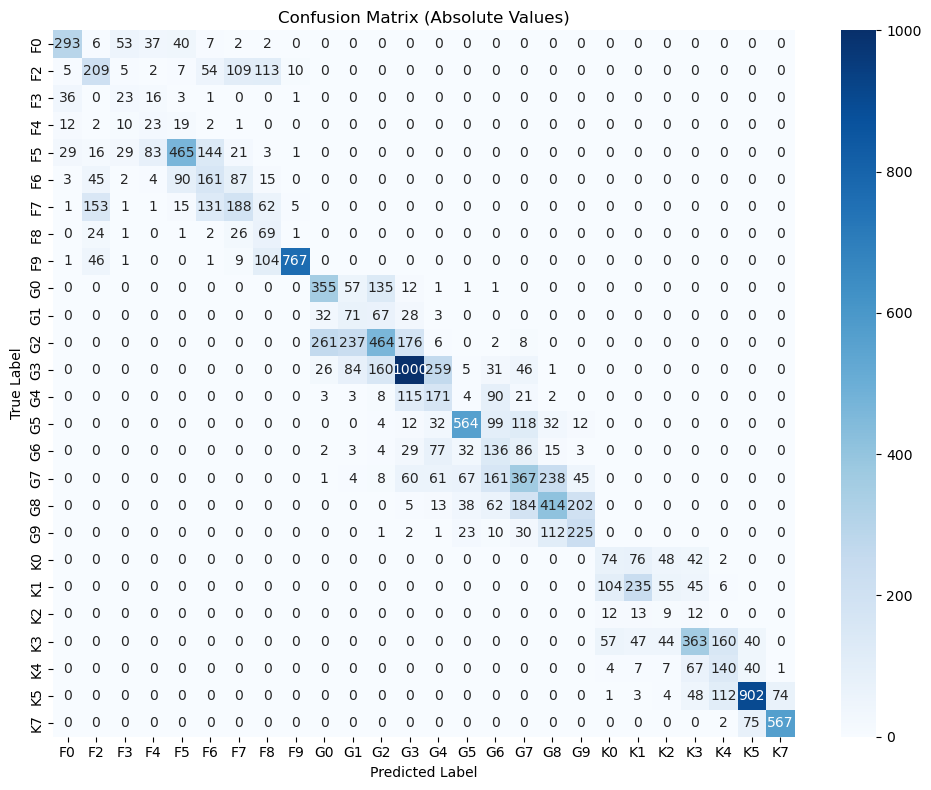

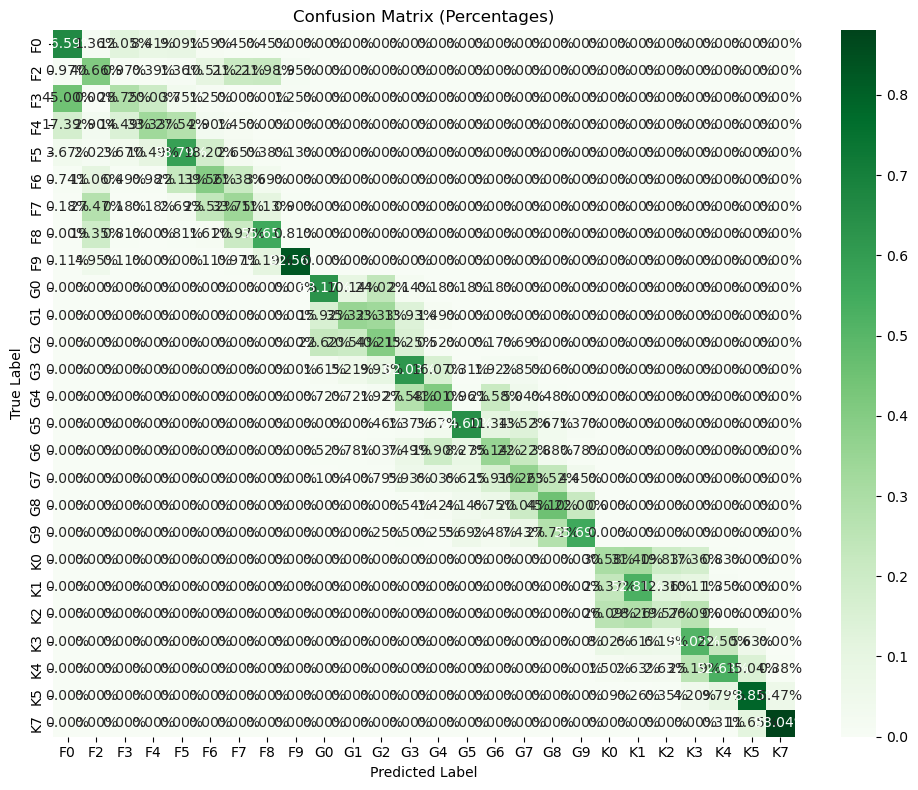


=== Remaining Classes After Filtering ===
full_class
G3       5375
G2       3846
K5       3813
G7       3374
F9       3097
G8       3059
G5       2911
F5       2638
K3       2371
K7       2146
G0       1872
F7       1857
F2       1712
K1       1482
F0       1465
G4       1391
F6       1355
G9       1347
G6       1289
K4        886
K0        807
G1        669
F8        414
F3        268
F4        230
K2        152
A7V        56
A6IV       42
A5V        20
A7IV       16
A9V        15
A8III      12
Name: count, dtype: int64


In [15]:
# Create confusion matrix
labels = sorted(set(y_val_combined))                                          # Sorted unique labels
cm = best_cm        # Absolute confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]           # Normalized matrix (percentages)

# Plot absolute confusion matrix
plt.figure(figsize=(10, 8))                                                  # Figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',                           # Absolute heatmap
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix (Absolute Values)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))                                                  # Figure size
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',            # Percentage heatmap
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display remaining classes
print("\n=== Remaining Classes After Filtering ===")
print(df_filtered['full_class'].value_counts())                